# Compare 

In [1]:
import json
import os
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import gaussian_kde

sns.set(style="whitegrid")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Define the directory for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse')
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with predictions
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

In [2]:
df['tweedie_val_hat'] = df.apply(lambda row: row['iwi_hat'] - ((correction_values[row['cv_fold']]['val_sigma'] ** 2) * row['val_score']), axis=1)
df['tweedie_train_hat'] = df.apply(lambda row: row['iwi_hat'] - ((correction_values[row['cv_fold']]['train_sigma'] ** 2) * row['train_score']), axis=1)
df

cluster_id        lon        lat  rural    region_id   country  \
0        AO.Bengo.71.135  13.640789  -8.589805  False     AO.Bengo    Angola   
1        AO.Bengo.71.158  14.122619  -7.718385   True     AO.Bengo    Angola   
2        AO.Bengo.71.169  13.654425  -8.592545  False     AO.Bengo    Angola   
3        AO.Bengo.71.203  13.517859  -8.652260   True     AO.Bengo    Angola   
4        AO.Bengo.71.208  13.721998  -7.852511   True     AO.Bengo    Angola   
...                  ...        ...        ...    ...          ...       ...   
68614  ZW.Midlands.72.37  30.008579 -20.911177   True  ZW.Midlands  Zimbabwe   
68615  ZW.Midlands.72.52  29.860028 -20.402214   True  ZW.Midlands  Zimbabwe   
68616  ZW.Midlands.72.69  30.172833 -20.724753   True  ZW.Midlands  Zimbabwe   
68617  ZW.Midlands.72.91  29.820084 -19.453466  False  ZW.Midlands  Zimbabwe   
68618  ZW.Midlands.72.97  29.773865 -19.452031  False  ZW.Midlands  Zimbabwe   

                            survey  month  year        iwi cv_fold    iwi_hat  \
0      Angola 2015-16 Standard DHS     11  2015  62.334459       C  56.657234   
1      Angola 2015-16 Standard DHS      2  2016   8.226589       B  20.742233   
2      Angola 2015-16 Standard DHS     10  2015  62.760211       E  62.706966   
3      Angola 2015-16 Standard DHS      1  2016  68.211697       B  36.631844   
4      Angola 2015-16 Standard DHS     11  2015  14.825944       B  13.755335   
...                            ...    ...   ...        ...     ...        ...   
68614   Zimbabwe 2015 Standard DHS      9  2015  27.791567       C  28.759209   
68615   Zimbabwe 2015 Standard DHS     10  2015  36.929878       D  25.726067   
68616   Zimbabwe 2015 Standard DHS     10  2015  24.406326       A  19.439295   
68617   Zimbabwe 2015 Standard DHS      7  2015  59.887344       C  52.122390   
68618   Zimbabwe 2015 Standard DHS      7  2015  58.386951       D  59.403778   

       train_score  val_score  tweedie_val_hat  tweedie_train_hat  
0        -0.014410  -0.021923        58.809665          57.258953  
1        -0.094204  -0.066349        26.867982          23.469723  
2        -0.053738  -0.055561        68.172591          64.863023  
3        -0.007247  -0.009686        37.526137          36.841659  
4         0.100273   0.117156         2.938793          10.852142  
...            ...        ...              ...                ...  
68614    -0.056823  -0.055449        34.203368          31.131985  
68615    -0.084823  -0.089179        34.703563          28.240046  
68616    -0.069061  -0.050615        24.401294          22.569272  
68617    -0.009243  -0.018232        53.912500          52.508352  
68618    -0.026194  -0.030636        62.487886          60.180115  

[68619 rows x 16 columns]

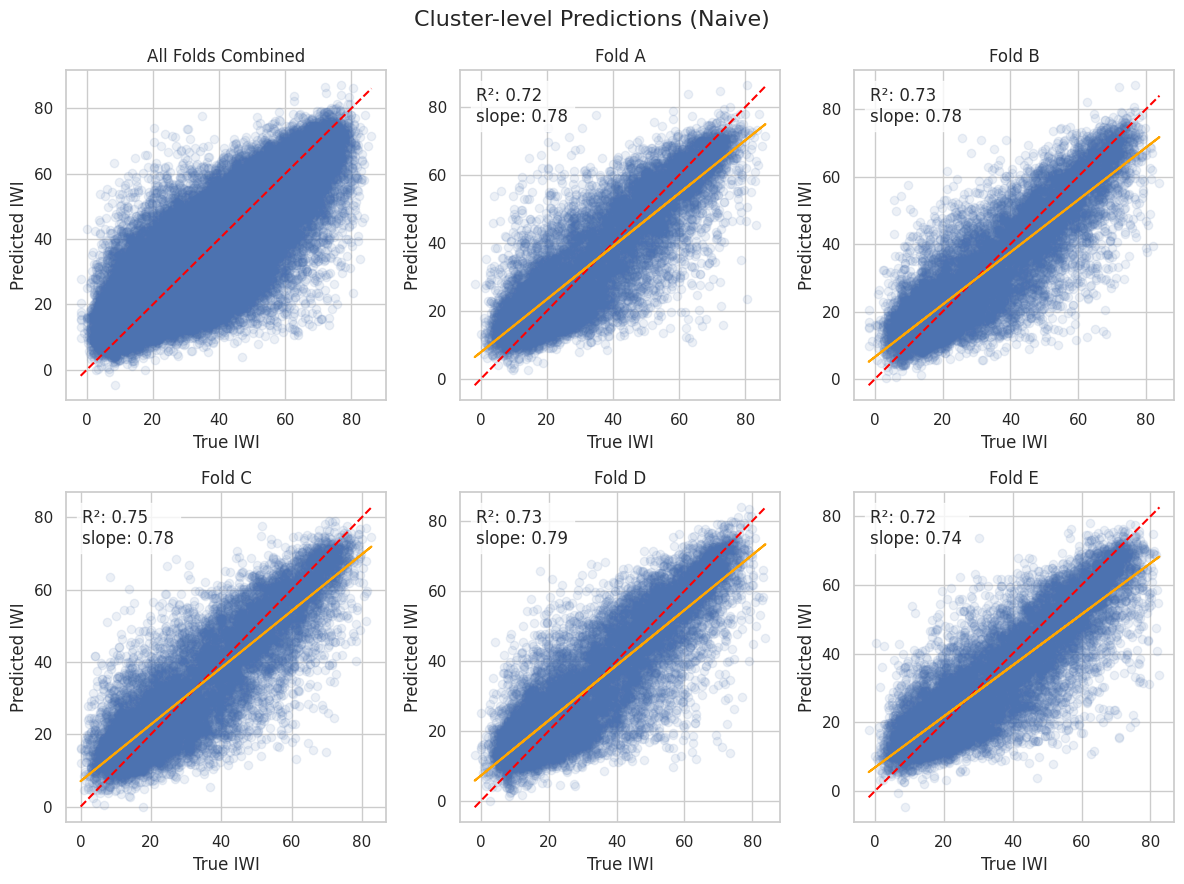

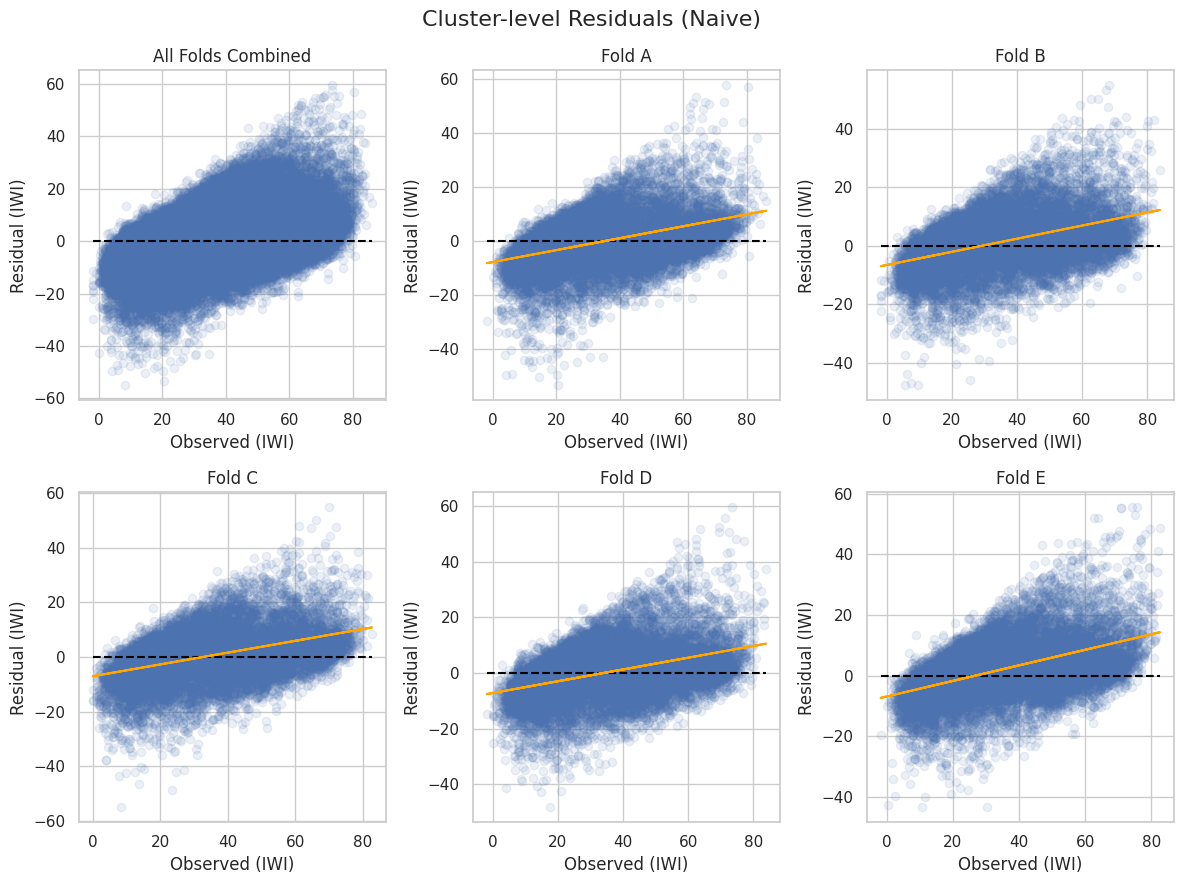

In [5]:
def plot_scatter_per_fold(df, pred_column='iwi_hat', title=None):
    # Plot the sctatter plots for each fold in subplots
    plt.figure(figsize=(12, 9))

    plt.subplot(2, 3, 1)
    plt.scatter(df['iwi'], df[pred_column], alpha=0.1)
    plt.plot([df['iwi'].min(), df['iwi'].max()], [df['iwi'].min(), df['iwi'].max()], color='red', linestyle='--')

    plt.xlabel('True IWI')
    plt.ylabel('Predicted IWI')
    plt.title(f'All Folds Combined')

    for i, fold in enumerate(folds):
        plt.subplot(2, 3, i + 2)
        fold_data = df[df['cv_fold'] == fold]
        plt.scatter(fold_data['iwi'], fold_data[pred_column], alpha=0.1)
        plt.plot([fold_data['iwi'].min(), fold_data['iwi'].max()], [fold_data['iwi'].min(), fold_data['iwi'].max()], color='red', linestyle='--')

        # Add a box with R^2 and RMSE
        r2 = r2_score(fold_data['iwi'], fold_data[pred_column])
        slope_model = LinearRegression().fit(fold_data['iwi'].values.reshape(-1, 1), fold_data[pred_column])
        plt.plot(fold_data['iwi'], slope_model.predict(fold_data['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')
        plt.text(0.05, 0.95, f'R²: {r2:.2f}\nslope: {slope_model.coef_[0]:.2f}', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        plt.xlabel('True IWI')
        plt.ylabel('Predicted IWI')
        plt.title(f'Fold {fold}')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_residual_scatter_per_fold(df, pred_column='iwi_hat', title=None):
    # Plot the sctatter plots for each fold in subplots
    plt.figure(figsize=(12, 9))

    plt.subplot(2, 3, 1)
    plt.scatter(df['iwi'], df['iwi'] - df[pred_column], alpha=0.1)
    plt.plot([df['iwi'].min(), df['iwi'].max()], [0, 0], color='black', linestyle='--')

    plt.xlabel('Observed (IWI)')
    plt.ylabel('Residual (IWI)')
    plt.title(f'All Folds Combined')

    for i, fold in enumerate(folds):
        plt.subplot(2, 3, i + 2)
        fold_data = df[df['cv_fold'] == fold]
        plt.scatter(fold_data['iwi'], fold_data['iwi'] - fold_data[pred_column], alpha=0.1)
        plt.plot([fold_data['iwi'].min(), fold_data['iwi'].max()], [0, 0], color='black', linestyle='--')

        slope_model = LinearRegression().fit(fold_data['iwi'].values.reshape(-1, 1), fold_data['iwi'] - fold_data[pred_column])
        plt.plot(fold_data['iwi'], slope_model.predict(fold_data['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')

        plt.xlabel('Observed (IWI)')
        plt.ylabel('Residual (IWI)')
        plt.title(f'Fold {fold}')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_scatter_per_fold(df, pred_column='iwi_hat', title='Cluster-level Predictions (Naive)')
plot_residual_scatter_per_fold(df, pred_column='iwi_hat', title='Cluster-level Residuals (Naive)')

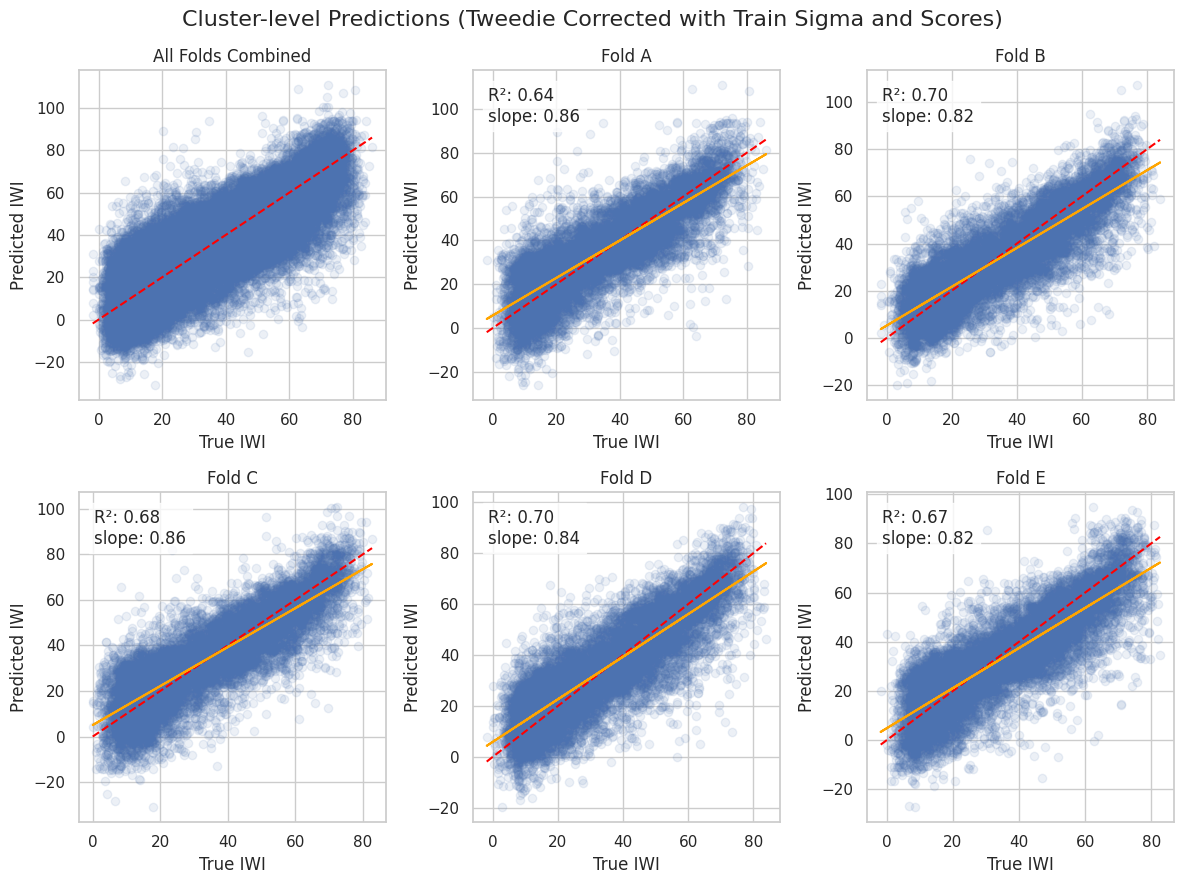

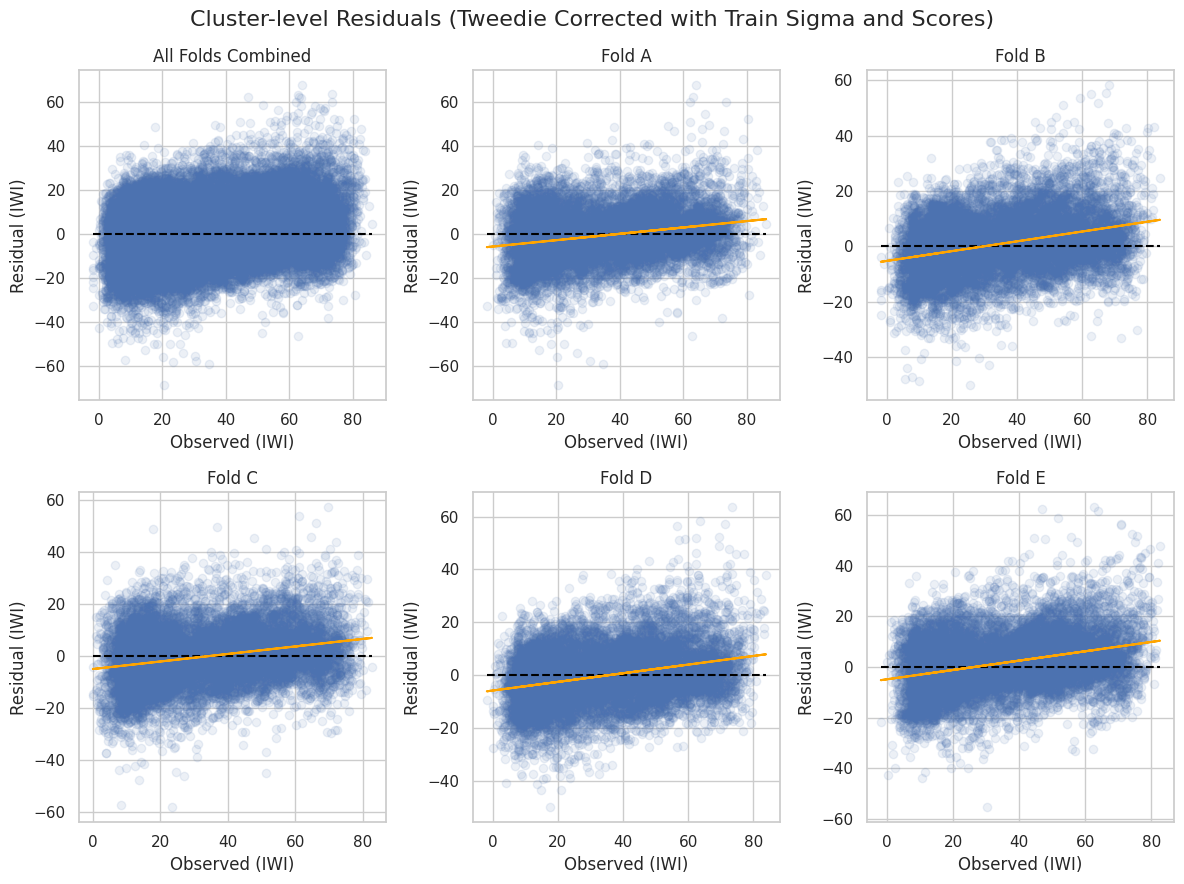

In [6]:
plot_scatter_per_fold(df, pred_column='tweedie_train_hat', title='Cluster-level Predictions (Tweedie Corrected with Train Sigma and Scores)')
plot_residual_scatter_per_fold(df, pred_column='tweedie_train_hat', title='Cluster-level Residuals (Tweedie Corrected with Train Sigma and Scores)')

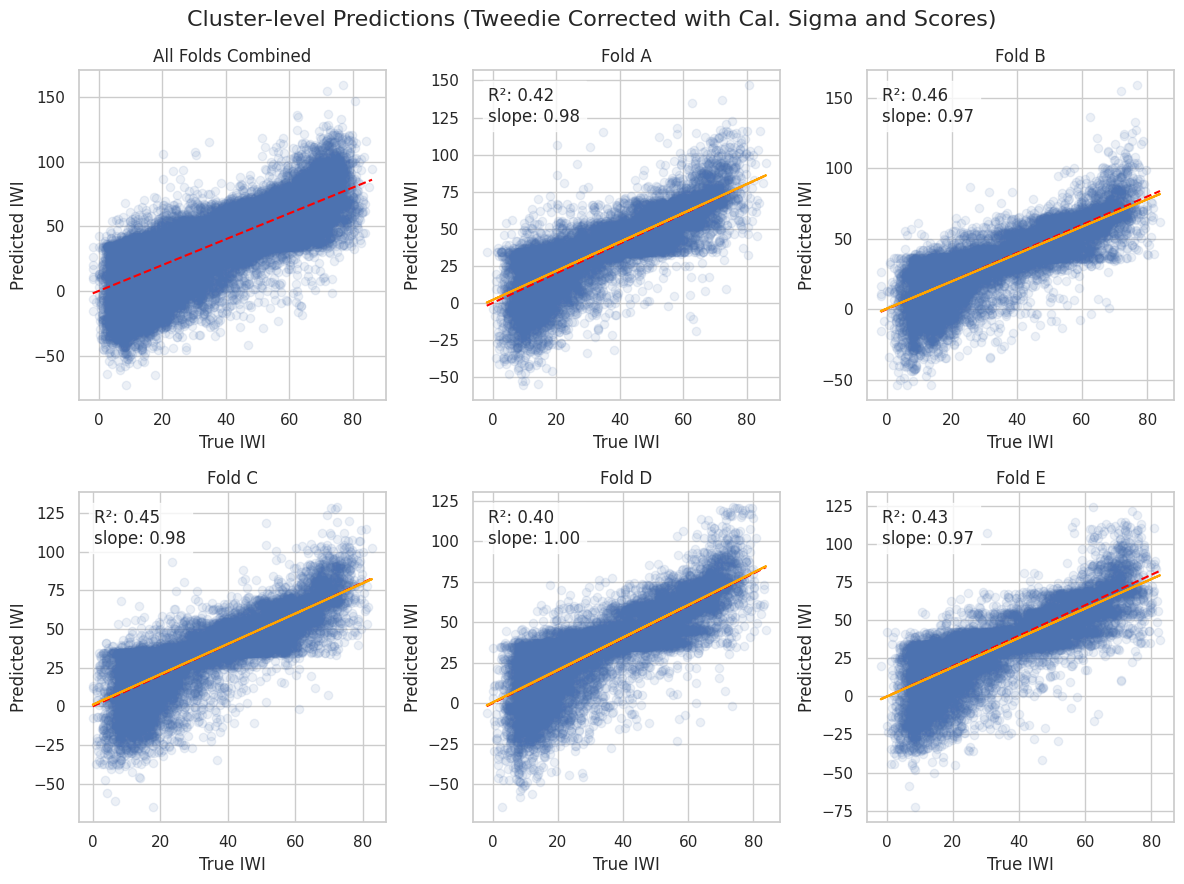

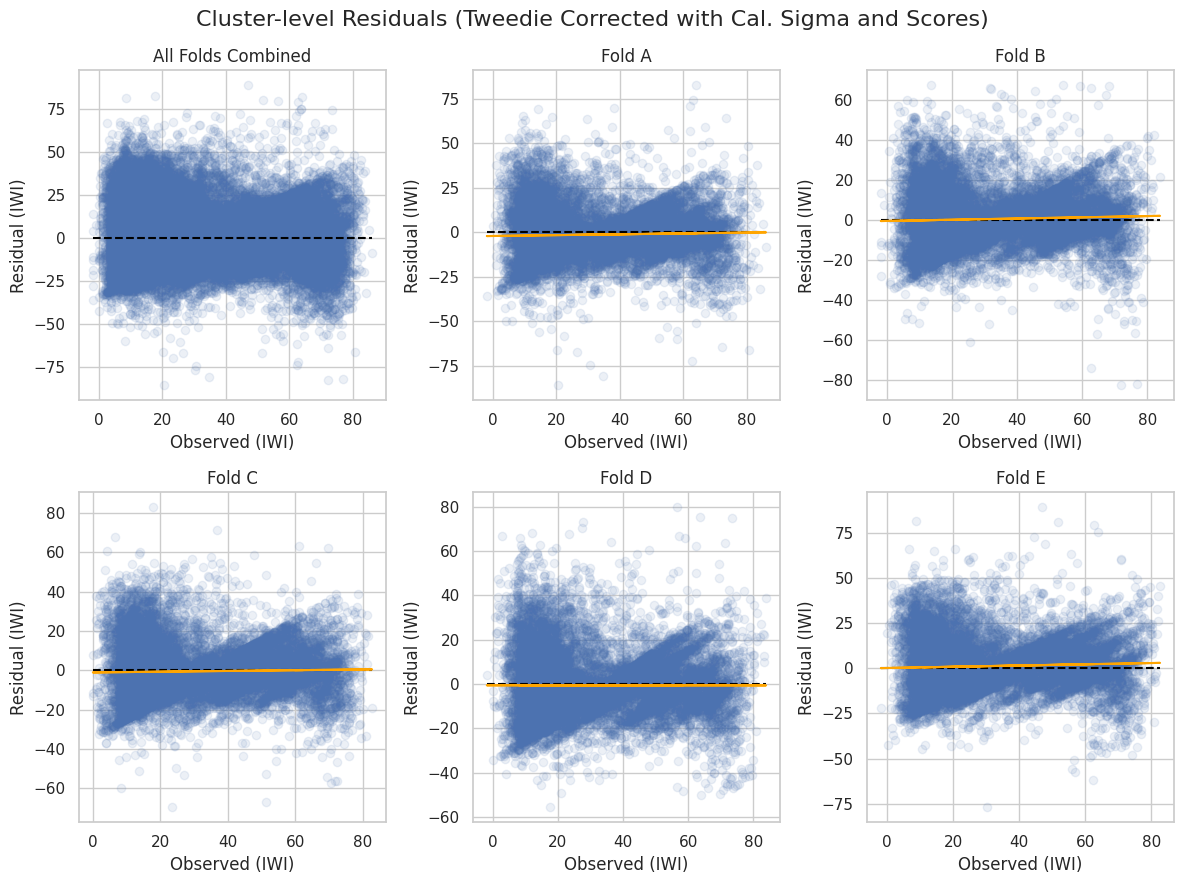

In [7]:
plot_scatter_per_fold(df, pred_column='tweedie_val_hat', title='Cluster-level Predictions (Tweedie Corrected with Cal. Sigma and Scores)')
plot_residual_scatter_per_fold(df, pred_column='tweedie_val_hat', title='Cluster-level Residuals (Tweedie Corrected with Cal. Sigma and Scores)')

In [40]:
n_quantiles = 50
quantile_values = np.quantile(df['iwi'].values, np.linspace(0, 1, n_quantiles+1))
df['iwi_quantile'] = pd.cut(df['iwi'], bins=quantile_values, labels=list(range(n_quantiles)), include_lowest=True)
df


cluster_id        lon        lat  rural    region_id   country  \
0        AO.Bengo.71.135  13.640789  -8.589805  False     AO.Bengo    Angola   
1        AO.Bengo.71.158  14.122619  -7.718385   True     AO.Bengo    Angola   
2        AO.Bengo.71.169  13.654425  -8.592545  False     AO.Bengo    Angola   
3        AO.Bengo.71.203  13.517859  -8.652260   True     AO.Bengo    Angola   
4        AO.Bengo.71.208  13.721998  -7.852511   True     AO.Bengo    Angola   
...                  ...        ...        ...    ...          ...       ...   
68614  ZW.Midlands.72.37  30.008579 -20.911177   True  ZW.Midlands  Zimbabwe   
68615  ZW.Midlands.72.52  29.860028 -20.402214   True  ZW.Midlands  Zimbabwe   
68616  ZW.Midlands.72.69  30.172833 -20.724753   True  ZW.Midlands  Zimbabwe   
68617  ZW.Midlands.72.91  29.820084 -19.453466  False  ZW.Midlands  Zimbabwe   
68618  ZW.Midlands.72.97  29.773865 -19.452031  False  ZW.Midlands  Zimbabwe   

                            survey  month  year        iwi cv_fold    iwi_hat  \
0      Angola 2015-16 Standard DHS     11  2015  62.334459       C  56.657234   
1      Angola 2015-16 Standard DHS      2  2016   8.226589       B  20.742233   
2      Angola 2015-16 Standard DHS     10  2015  62.760211       E  62.706966   
3      Angola 2015-16 Standard DHS      1  2016  68.211697       B  36.631844   
4      Angola 2015-16 Standard DHS     11  2015  14.825944       B  13.755335   
...                            ...    ...   ...        ...     ...        ...   
68614   Zimbabwe 2015 Standard DHS      9  2015  27.791567       C  28.759209   
68615   Zimbabwe 2015 Standard DHS     10  2015  36.929878       D  25.726067   
68616   Zimbabwe 2015 Standard DHS     10  2015  24.406326       A  19.439295   
68617   Zimbabwe 2015 Standard DHS      7  2015  59.887344       C  52.122390   
68618   Zimbabwe 2015 Standard DHS      7  2015  58.386951       D  59.403778   

       train_score  val_score  tweedie_val_hat  tweedie_train_hat iwi_quantile  
0        -0.014410  -0.021923        58.809665          57.258953           45  
1        -0.094204  -0.066349        26.867982          23.469723            2  
2        -0.053738  -0.055561        68.172591          64.863023           45  
3        -0.007247  -0.009686        37.526137          36.841659           47  
4         0.100273   0.117156         2.938793          10.852142           10  
...            ...        ...              ...                ...          ...  
68614    -0.056823  -0.055449        34.203368          31.131985           25  
68615    -0.084823  -0.089179        34.703563          28.240046           31  
68616    -0.069061  -0.050615        24.401294          22.569272           22  
68617    -0.009243  -0.018232        53.912500          52.508352           44  
68618    -0.026194  -0.030636        62.487886          60.180115           43  

[68619 rows x 17 columns]

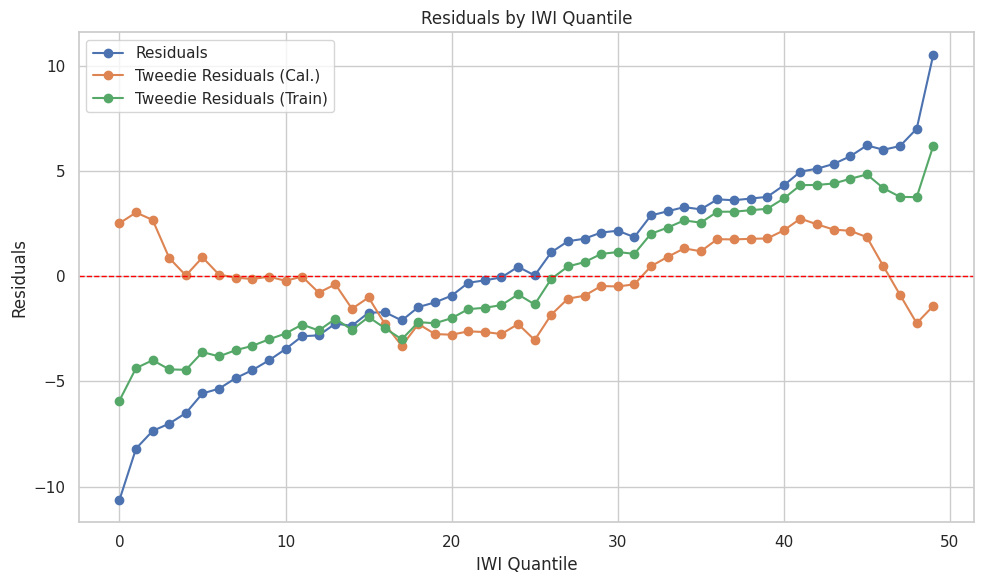

In [43]:
df['res'] = df['iwi'] - df['iwi_hat']
df['res_tweedie_val'] = df['iwi'] - df['tweedie_val_hat']
df['res_tweedie_train'] = df['iwi'] - df['tweedie_train_hat']

res_df = df.groupby('iwi_quantile')[['res', 'res_tweedie_val', 'res_tweedie_train']].mean()

def plot_residuals(res_df, title=None):
    plt.figure(figsize=(10, 6))
    plt.plot(res_df.index, res_df['res'], label='Residuals', marker='o')
    plt.plot(res_df.index, res_df['res_tweedie_val'], label='Tweedie Residuals (Cal.)', marker='o')
    plt.plot(res_df.index, res_df['res_tweedie_train'], label='Tweedie Residuals (Train)', marker='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('IWI Quantile')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_residuals(res_df, title='Residuals by IWI Quantile')

# Slope by time

In [1]:
import json
import os
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

sns.set(style="whitegrid")
tqdm.pandas()

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

EPOCH_MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_linear_epochs=0_num_top_epochs=0_num_full_epochs=20')

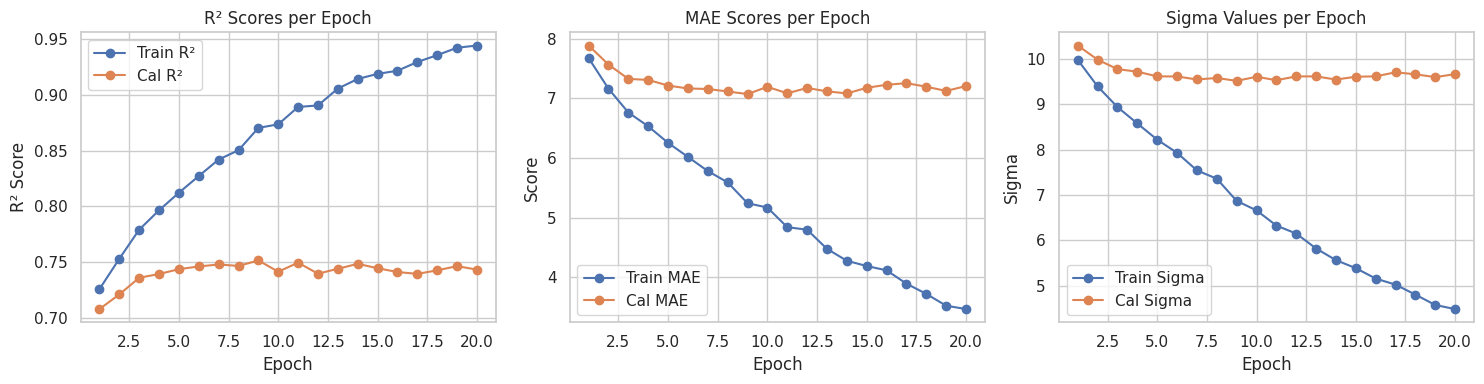

In [30]:
folds = ['A', 'B', 'C', 'D', 'E']
train_r2_scores = []
train_mae_scores = []
cal_r2_scores = []
cal_mae_scores = []
test_r2_scores = []
test_mae_scores = []
train_sigma = []
cal_sigma = []

for i in range(20):
    # df = pd.read_csv(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'dhs_with_imgs_predictions.csv'))
    with open(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'metrics.json'), 'r') as f:
        metrics = json.load(f)

    with open(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'correction_values.json'), 'r') as f:
        correction_values = json.load(f)

    train_r2_scores.append(np.mean([metrics[fold]['train_r2'] for fold in folds]))
    train_mae_scores.append(np.mean([metrics[fold]['train_mae'] for fold in folds]))
    cal_r2_scores.append(np.mean([metrics[fold]['val_r2'] for fold in folds]))
    cal_mae_scores.append(np.mean([metrics[fold]['val_mae'] for fold in folds]))
    test_r2_scores.append(np.mean([metrics[fold]['test_r2'] for fold in folds]))
    test_mae_scores.append(np.mean([metrics[fold]['test_mae'] for fold in folds]))

    train_sigma.append(np.mean([correction_values[fold]['train_sigma'] for fold in folds]))
    cal_sigma.append(np.mean([correction_values[fold]['val_sigma'] for fold in folds]))

# Plotting the metrics
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, 21), train_r2_scores, label='Train R²', marker='o')
plt.plot(range(1, 21), cal_r2_scores, label='Cal R²', marker='o')
#plt.plot(range(1, 21), test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Scores per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 21), train_mae_scores, label='Train MAE', marker='o')
plt.plot(range(1, 21), cal_mae_scores, label='Cal MAE', marker='o')
#plt.plot(range(1, 21), test_mae_scores, label='Test MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('MAE Scores per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 21), train_sigma, label='Train Sigma', marker='o')
plt.plot(range(1, 21), cal_sigma, label='Cal Sigma', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Sigma')
plt.title('Sigma Values per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

    

In [37]:
def get_survey_means(survey_df, correction_values):

    survey_means = survey_df.groupby('cv_fold')[['iwi', 'iwi_hat', 'val_score', 'train_score']].mean().sort_values('cv_fold')

    for i, row in survey_means.iterrows():
        fold_corr_vals = correction_values[row.name]
        survey_means.loc[row.name, 'lcc_val_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['val_lcc_intercept']) / fold_corr_vals['val_lcc_slope']
        survey_means.loc[row.name, 'lcc_train_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['train_lcc_intercept']) / fold_corr_vals['train_lcc_slope']

        survey_means.loc[row.name, 'tweedie_train_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['train_score']
        survey_means.loc[row.name, 'tweedie_val_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['val_sigma'] ** 2 * row['val_score']
        survey_means.loc[row.name, 'tweedie_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['val_score']

    survey_means = survey_means.drop(columns=['val_score', 'train_score'])

    return survey_means

maes = []
slopes = []
tweedie_maes = []
tweedie_slopes = []
tweedie_train_maes = []
tweedie_val_maes = []
tweedie_train_slopes = []
tweedie_val_slopes = []

for i in range(20):
    df = pd.read_csv(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'dhs_with_imgs_predictions.csv'))
    with open(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'correction_values.json'), 'r') as f:
        correction_values = json.load(f)

    survey_means_df = df.groupby('survey').apply(lambda x: get_survey_means(x, correction_values)).reset_index()
    mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['iwi_hat'])
    slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['iwi_hat']).coef_[0]

    tweedie_mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['tweedie_iwi_hat'])
    tweedie_slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['tweedie_iwi_hat']).coef_[0]
    tweedie_train_mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['tweedie_train_iwi_hat'])
    tweedie_val_mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['tweedie_val_iwi_hat'])
    tweedie_train_slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['tweedie_train_iwi_hat']).coef_[0]
    tweedie_val_slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['tweedie_val_iwi_hat']).coef_[0]
    
    maes.append(mae)
    slopes.append(slope)
    tweedie_maes.append(tweedie_mae)
    tweedie_slopes.append(tweedie_slope)
    tweedie_train_maes.append(tweedie_train_mae)
    tweedie_val_maes.append(tweedie_val_mae)
    tweedie_train_slopes.append(tweedie_train_slope)
    tweedie_val_slopes.append(tweedie_val_slope)


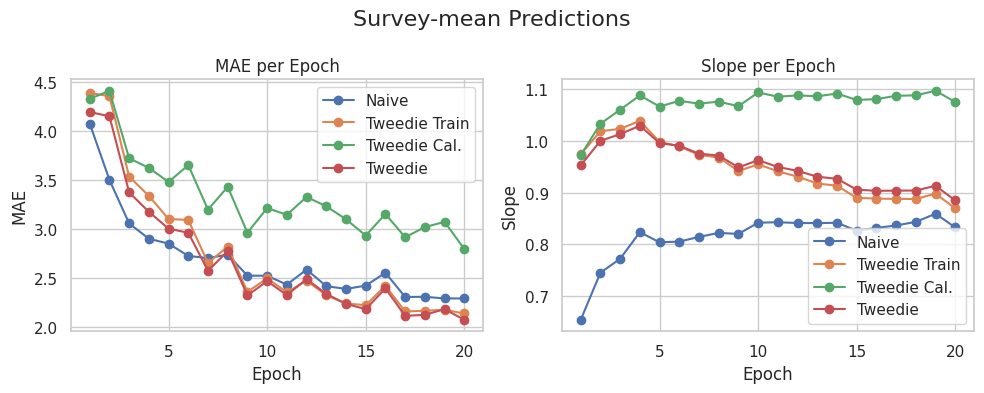

In [36]:
# Plotting the metrics
plt.figure(figsize=(10, 4))

# MAE subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), maes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_maes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_maes, label='Tweedie Cal.', marker='o')
plt.plot(range(1, 21), tweedie_maes, label='Tweedie', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE per Epoch')
plt.legend()

# Slope subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), slopes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_slopes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_slopes, label='Tweedie Cal.', marker='o')
plt.plot(range(1, 21), tweedie_slopes, label='Tweedie', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Slope')
plt.title('Slope per Epoch')
plt.legend()

plt.suptitle('Survey-mean Predictions', fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
maes = []
slopes = []
tweedie_train_maes = []
tweedie_val_maes = []
tweedie_train_slopes = []
tweedie_val_slopes = []

for i in range(20):
    df = pd.read_csv(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'dhs_with_imgs_predictions.csv'))
    with open(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'correction_values.json'), 'r') as f:
        correction_values = json.load(f)

    survey_means_df = df.groupby('region_id').apply(lambda x: get_survey_means(x, correction_values)).reset_index().dropna()
    mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['iwi_hat'])
    slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['iwi_hat']).coef_[0]

    tweedie_train_mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['tweedie_train_iwi_hat'])
    tweedie_val_mae = mean_absolute_error(survey_means_df['iwi'], survey_means_df['tweedie_val_iwi_hat'])
    tweedie_train_slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['tweedie_train_iwi_hat']).coef_[0]
    tweedie_val_slope = LinearRegression().fit(survey_means_df['iwi'].values.reshape(-1, 1), survey_means_df['tweedie_val_iwi_hat']).coef_[0]
    
    maes.append(mae)
    slopes.append(slope)
    tweedie_train_maes.append(tweedie_train_mae)
    tweedie_val_maes.append(tweedie_val_mae)
    tweedie_train_slopes.append(tweedie_train_slope)
    tweedie_val_slopes.append(tweedie_val_slope)

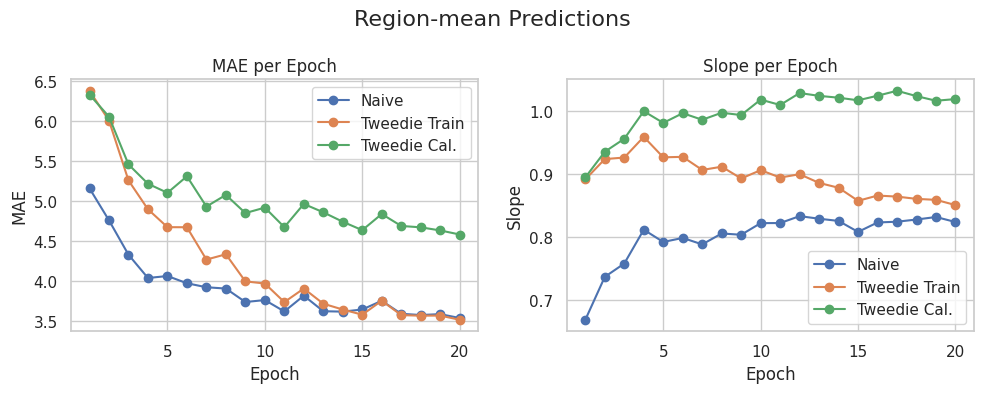

In [34]:
# Plotting the metrics
plt.figure(figsize=(10, 4))

# MAE subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), maes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_maes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_maes, label='Tweedie Cal.', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE per Epoch')
plt.legend()

# Slope subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), slopes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_slopes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_slopes, label='Tweedie Cal.', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Slope')
plt.title('Slope per Epoch')
plt.legend()

plt.suptitle('Region-mean Predictions', fontsize=16)
plt.tight_layout()
plt.show()

## Apply to causal task

In [38]:
exp_dir = os.path.join(DATA_DIR, 'cindy_experiments')
interventions_df = pd.read_csv(os.path.join(exp_dir, 'interim/interventions.csv'))
interventions_dhs_link_df = pd.read_csv(os.path.join(exp_dir, 'interim/intervention_dhs_link.csv'))

In [39]:
trials_df = interventions_df[['funder', 'ad_sector_codes']].drop_duplicates().reset_index(drop=True)

ad_sector_names = {
    #Social Infrastructure & Services
    110: "Education",
    120: "Health",
    130: "Population Policies / Programmes and Reproductive Health",
    140: "Water Supply and Sanitation",
    150: "Government and Civil Society",
    160: "Other Social Infrastructure and Services",
    # Economic Infrastructure & Services 
    210: "Transport and Storage",
    220: "Communications",
    230: "Energy Generation and Supply",
    240: "Banking and Financial Services",
    250: "Business and Other Services",
    # Production
    310: "Agriculture, Forestry and Fishing",
    320: "Industry, Mining, Construction",
    330: "Trade and Tourism",
    # Direct Aid
    520: "Developmental Food Aid/Food Security Assistance",
    700: "Emergency Response",
    600: "Action Relating to Debt",
    920: "Support to Non-governmental Organizations (NGOs) and Government Organizations",
    530: "Non-food commodity assistance",
    # Other
    410: "General Environment Protection",
    420: "Women in Development",
    430: "Other Multisector",
    998: "Unallocated / Unspecified"
}

trials_df['ad_sector_names'] = trials_df['ad_sector_codes'].map(ad_sector_names)

trials_df

funder  ad_sector_codes                                    ad_sector_names
0      CH              230                       Energy Generation and Supply
1      CH              220                                     Communications
2      CH              210                              Transport and Storage
3      CH              110                                          Education
4      CH              150                       Government and Civil Society
5      CH              320                     Industry, Mining, Construction
6      CH              310                  Agriculture, Forestry and Fishing
7      CH              120                                             Health
8      CH              520    Developmental Food Aid/Food Security Assistance
9      CH              140                        Water Supply and Sanitation
10     CH              420                               Women in Development
11     CH              700                                 Emergency Response
12     CH              920  Support to Non-governmental Organizations (NGO...
13     CH              160           Other Social Infrastructure and Services
14     CH              430                                  Other Multisector
15     CH              998                          Unallocated / Unspecified
16     CH              130  Population Policies / Programmes and Reproduct...
17     CH              330                                  Trade and Tourism
18     CH              530                      Non-food commodity assistance
19     CH              410                     General Environment Protection
20     CH              600                            Action Relating to Debt
21     WB              230                       Energy Generation and Supply
22     WB              150                       Government and Civil Society
23     WB              160           Other Social Infrastructure and Services
24     WB              240                     Banking and Financial Services
25     WB              310                  Agriculture, Forestry and Fishing
26     WB              410                     General Environment Protection
27     WB              140                        Water Supply and Sanitation
28     WB              210                              Transport and Storage
29     WB              320                     Industry, Mining, Construction
30     WB              110                                          Education
31     WB              120                                             Health
32     WB              330                                  Trade and Tourism
33     WB              220                                     Communications

In [40]:
def get_PPI_ATE(treated_df, control_df, labeled_frac=0.1):
    """
    Calculate the ATE with PPI (Prediction Powered Inference) between treated and control groups.
    """

    # Sample a fraction of the treated and control groups to use as the "fresh" labeled data
    n_samples = len(treated_df) + len(control_df)
    sample_ixs = np.random.choice(np.arange(n_samples), size=int(n_samples * labeled_frac), replace=False)
    treated_sample_ixs = sample_ixs[sample_ixs < len(treated_df)]
    control_sample_ixs = sample_ixs[sample_ixs >= len(treated_df)] - len(treated_df)

    labeled_treated_df = treated_df.iloc[treated_sample_ixs]
    labeled_control_df = control_df.iloc[control_sample_ixs]
    
    # Use the remaining data as unlabeled
    unlabeled_treated_df = treated_df.drop(labeled_treated_df.index)
    unlabeled_control_df = control_df.drop(labeled_control_df.index)

    # Get the biases with the labeled data
    treated_bias = (labeled_treated_df['iwi'] - labeled_treated_df['iwi_hat']).mean()
    control_bias = (labeled_control_df['iwi'] - labeled_control_df['iwi_hat']).mean()

    ppi_ate = (unlabeled_treated_df['iwi_hat'].mean() - unlabeled_control_df['iwi_hat'].mean()) + (treated_bias - control_bias)
    return ppi_ate

def get_LCC_ATE(treated_df, control_df, correction_values):

    treated_mean = treated_df.apply(lambda row: row['iwi_hat'] / correction_values[row['cv_fold']]['val_lcc_slope'], axis=1).mean()
    control_mean = control_df.apply(lambda row: row['iwi_hat'] / correction_values[row['cv_fold']]['val_lcc_slope'], axis=1).mean()
    lcc_ate = treated_mean - control_mean
    return lcc_ate

def get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='train_score'):

    treated_preds = treated_df.apply(lambda row: row['iwi_hat'] - correction_values[row['cv_fold']][sigma_name]**2 * row[score_name], axis=1)
    control_preds = control_df.apply(lambda row: row['iwi_hat'] - correction_values[row['cv_fold']][sigma_name]**2 * row[score_name], axis=1)
    tweedie_ate = treated_preds.mean() - control_preds.mean()
    return tweedie_ate

In [41]:
def get_ates_of_trial(row, interventions_df, dhs_df):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = dhs_df['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = dhs_df[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (dhs_df['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = dhs_df[control_clusters_ixs]

    ate = treated_df['iwi'].mean() - control_df['iwi'].mean()
    ate_hat = treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()
    ppi_ate = get_PPI_ATE(treated_df, control_df, labeled_frac=0.1)
    lcc_ate = get_LCC_ATE(treated_df, control_df, correction_values)
    tweedie_ate_train_train = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='train_score')
    tweedie_ate_train_val = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='val_score')
    tweedie_ate_val_train = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='val_sigma', score_name='train_score')
    tweedie_ate_val_val = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='val_sigma', score_name='val_score')

    row['ate'] = ate
    row['ate_hat'] = ate_hat
    row['ppi_ate'] = ppi_ate
    row['lcc_ate'] = lcc_ate
    row['tweedie_ate_train_train'] = tweedie_ate_train_train
    row['tweedie_ate_train_val'] = tweedie_ate_train_val
    row['tweedie_ate_val_train'] = tweedie_ate_val_train
    row['tweedie_ate_val_val'] = tweedie_ate_val_val
    row['treated_count'] = len(treated_df)
    row['control_count'] = len(control_df)
    return row

In [44]:
out_trials_df = []

for i in range(20):
    print(f'Processing epoch {i+1}...')
    dhs_df = pd.read_csv(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'dhs_with_imgs_predictions.csv'))
    with open(os.path.join(EPOCH_MODELS_DIR, f'save_epoch_{i}', 'correction_values.json'), 'r') as f:
        correction_values = json.load(f)
    # Apply the function to each row of the trials_df
    epoch_out_trials_df = trials_df.progress_apply(get_ates_of_trial, axis=1, interventions_df=interventions_df, dhs_df=dhs_df)
    epoch_out_trials_df['epoch'] = i
    out_trials_df.append(epoch_out_trials_df)

out_trials_df = pd.concat(out_trials_df, ignore_index=True)

Processing epoch 1...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 2...


100%|██████████| 34/34 [00:26<00:00,  1.30it/s]


Processing epoch 3...


100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


Processing epoch 4...


100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


Processing epoch 5...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 6...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 7...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 8...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 9...


100%|██████████| 34/34 [00:26<00:00,  1.31it/s]


Processing epoch 10...


100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


Processing epoch 11...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 12...


100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


Processing epoch 13...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 14...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 15...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 16...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 17...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 18...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 19...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


Processing epoch 20...


100%|██████████| 34/34 [00:25<00:00,  1.31it/s]


In [58]:
maes = []
slopes = []
tweedie_train_maes = []
tweedie_val_maes = []
tweedie_train_slopes = []
tweedie_val_slopes = []
tweedie_train_val_slopes = []
tweedie_train_val_maes = []

for i in range(20):
    epoch_out_trials_df = out_trials_df[out_trials_df['epoch'] == i]
    # epoch_out_trials_df = epoch_out_trials_df[epoch_out_trials_df['treated_count'] > 100]
    epoch_out_trials_df = epoch_out_trials_df.dropna()
    slope, _ = np.polyfit(epoch_out_trials_df['ate'].values, epoch_out_trials_df['ate_hat'].values.astype(float), 1)
    mae = mean_absolute_error(epoch_out_trials_df['ate'].values, epoch_out_trials_df['ate_hat'].values)

    tweedie_train_slope, _ = np.polyfit(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_train_train'].values.astype(float), 1)
    tweedie_train_mae = mean_absolute_error(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_train_train'].values.astype(float))
    tweedie_val_slope, _ = np.polyfit(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_val_val'].values.astype(float), 1)
    tweedie_val_mae = mean_absolute_error(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_val_val'].values.astype(float))
    tweedie_train_val_slope, _ = np.polyfit(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_train_val'].values.astype(float), 1)
    tweedie_train_val_mae = mean_absolute_error(epoch_out_trials_df['ate'].values, epoch_out_trials_df['tweedie_ate_train_val'].values.astype(float))

    maes.append(mae)
    slopes.append(slope)
    tweedie_train_maes.append(tweedie_train_mae)
    tweedie_val_maes.append(tweedie_val_mae)
    tweedie_train_slopes.append(tweedie_train_slope)
    tweedie_val_slopes.append(tweedie_val_slope)
    tweedie_train_val_slopes.append(tweedie_train_val_slope)
    tweedie_train_val_maes.append(tweedie_train_val_mae)

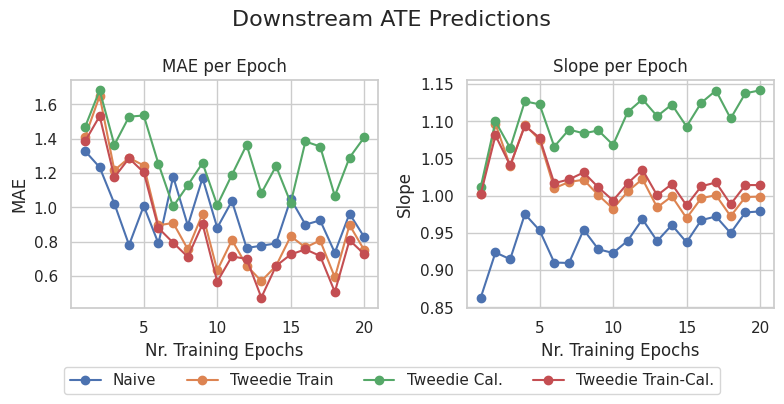

In [ ]:
# Plotting the metrics
plt.figure(figsize=(8, 4))

# MAE subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), maes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_maes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_maes, label='Tweedie Cal.', marker='o')
plt.plot(range(1, 21), tweedie_train_val_maes, label='Tweedie Train-Cal.', marker='o')
plt.xlabel('Nr. Training Epochs')
plt.ylabel('MAE')
plt.title('MAE per Epoch')

# Slope subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), slopes, marker='o')
plt.plot(range(1, 21), tweedie_train_slopes, marker='o')
plt.plot(range(1, 21), tweedie_val_slopes, marker='o')
plt.plot(range(1, 21), tweedie_train_val_slopes, marker='o')
plt.xlabel('Nr. Training Epochs')
plt.ylabel('Slope')
plt.title('Slope per Epoch')

# Add a common legend underneath the full figure
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.suptitle('Downstream ATE Predictions', fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 1])  # Adjust layout to make space for the legend
plt.show()

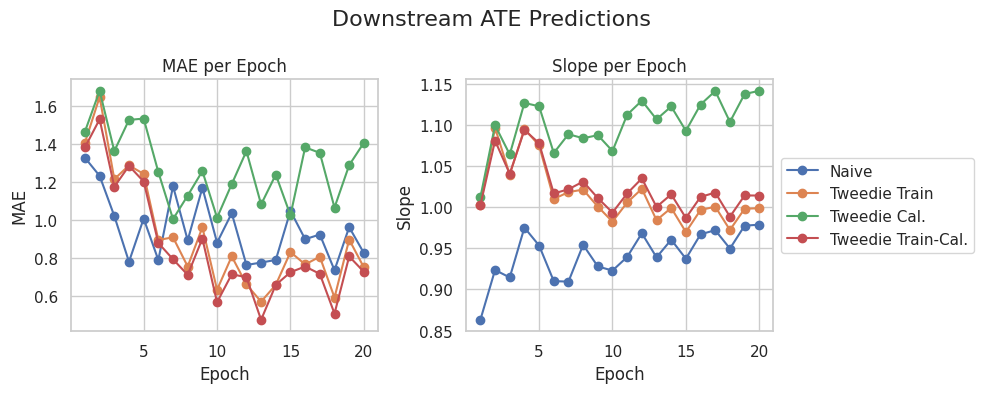

In [ ]:
# Plotting the metrics
plt.figure(figsize=(10, 4))

# MAE subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), maes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_val_maes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_maes, label='Tweedie Cal.', marker='o')
#plt.plot(range(1, 21), tweedie_train_val_maes, label='Tweedie Train-Cal.', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE per Epoch')

# Slope subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), slopes, label='Naive', marker='o')
plt.plot(range(1, 21), tweedie_train_val_slopes, label='Tweedie Train', marker='o')
plt.plot(range(1, 21), tweedie_val_slopes, label='Tweedie Cal.', marker='o')
# plt.plot(range(1, 21), tweedie_train_val_slopes, label='Tweedie Train-Cal.', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Slope')
plt.title('Slope per Epoch')

# Add a common legend to the right of the plots
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Downstream ATE Predictions', fontsize=16)
plt.tight_layout()
plt.show()